In [1]:
import pandas as pd
import akshare as ak

# 800自由现金流，季度更新
# https://www.csindex.com.cn/#/indices/family/detail?indexCode=932368
stocks = [
'000039',
'000426',
'000513',
'000568',
'000651',
'000708',
'000792',
'000807',
'000858',
'000933',
'002001',
'002056',
'002120',
'002352',
'002532',
'002714',
'300002',
'300073',
'300498',
'300724',
'300803',
'600066',
'600096',
'600219',
'600258',
'600295',
'600312',
'600352',
'600380',
'600482',
'600585',
'600873',
'600938',
'600968',
'601156',
'601168',
'601212',
'601225',
'601231',
'601600',
'601877',
'601880',
'601919',
'603129',
'603233',
'603816',
'603833',
'603885',
'603939',
'603993'
]
# 一次性获取全市场 A 股实时行情
spot_df = ak.stock_zh_a_spot_em()

/home/jovyan/data/.venv/lib/python3.11/site-packages/py_mini_racer/py_mini_racer.py:15: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


  0%|          | 0/57 [00:00<?, ?it/s]

In [2]:
# 只看我们关心的列
spot_df = spot_df[["代码", "名称", "流通市值"]]

# 过滤出你的股票
my_df = spot_df[spot_df["代码"].isin(stocks)]

In [3]:
def weekly_return(code):
    try:
        df = ak.stock_zh_a_hist(symbol=code, period="weekly", adjust="hfq")
        if len(df) >= 2:
            last_week_close = df.iloc[-2]["收盘"]
            this_week_close = df.iloc[-1]["收盘"]
            return round((this_week_close / last_week_close - 1) * 100, 2)
    except Exception as e:
        print(f"{code} 获取失败: {e}")
    return None

# 添加周涨幅
my_df["周涨幅(%)"] = my_df["代码"].apply(weekly_return)

/tmp/ipykernel_19706/1229572994.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_df["周涨幅(%)"] = my_df["代码"].apply(weekly_return)


In [4]:
my_df["市值_score"] = pd.qcut(my_df["流通市值"], 5, labels=[5,4,3,2,1]).astype(int)
my_df["周涨幅_score"] = pd.qcut(my_df["周涨幅(%)"], 5, labels=[5,4,3,2,1]).astype(int)

# 综合得分（简单相加，也可以加权）
my_df["因子总分"] = my_df["市值_score"] + my_df["周涨幅_score"]

# 排序看前10个
result = my_df.sort_values("因子总分", ascending=False).head(10)
result

/tmp/ipykernel_19706/2716460985.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_df["市值_score"] = pd.qcut(my_df["流通市值"], 5, labels=[5,4,3,2,1]).astype(int)
/tmp/ipykernel_19706/2716460985.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_df["周涨幅_score"] = pd.qcut(my_df["周涨幅(%)"], 5, labels=[5,4,3,2,1]).astype(int)
/tmp/ipykernel_19706/2716460985.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

,代码,名称,流通市值,周涨幅(%),市值_score,周涨幅_score,因子总分
2822,600380,健康元,2.361824e+10,0.29,5,5,10
4930,603233,大参林,1.942875e+10,-1.13,5,5,10
4101,002120,韵达股份,2.426637e+10,-0.50,5,5,10
2363,000039,中集集团,1.887154e+10,0.42,5,5,10
2426,600312,平高电气,2.203640e+10,0.42,5,5,10
5104,603939,益丰药房,2.921389e+10,-1.65,4,5,9
4811,300002,神州泰岳,2.613494e+10,-1.12,4,5,9
3213,600873,梅花生物,3.143773e+10,0.08,4,5,9
1035,600295,鄂尔多斯,2.046697e+10,1.53,5,3,8
2676,603885,吉祥航空,2.782423e+10,0.44,4,4,8


In [5]:
import empyrical
import alphalens as al

In [131]:
import pandas as pd
import akshare as ak
from tqdm import tqdm
import datetime as dt
import alphalens as al

# 股票池
codes = ['000039','000426','000513','000568','000651','000708','000792','000807',
         '000858','000933','002001','002056','002120','002352','002532','002714',
         '300002','300073','300498','300724','300803','600066','600096','600219',
         '600258','600295','600312','600352','600380','600482','600585','600873',
         '600938','600968','601156','601168','601212','601225','601231','601600',
         '601877','601880','601919','603129','603233','603816','603833','603885',
         '603939','603993']

start = '2018-01-02	'
end   = '2025-08-27'

tickers = codes

# ---------- 1. 拉后复权周 K ----------
def weekly_hfq(code):
    df = ak.stock_zh_a_hist(symbol=code, period="daily",
                            start_date=start.replace('-', ''),
                            end_date=end.replace('-', ''),
                            adjust="hfq")
    # 统一列名为小写英文
    df = df.rename(columns=str.lower)          # Date -> date
    df = df.rename(columns={'日期': 'date',   # 中文兜底
                            '收盘': 'close'})
    df = df[['date', 'close']].copy()
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values('date', inplace=True)
    df['code'] = code
    return df[['date', 'code', 'close']]

prices = []
for t in tqdm(tickers):
    prices.append(weekly_hfq(t))
prices = pd.concat(prices, ignore_index=True)

# 构造价格透视表：行=date, 列=code
prices_pivot = prices.pivot(index='date', columns='code', values='close')

100%|██████████| 50/50 [00:34<00:00,  1.45it/s]


code,000039,000426,000513,000568,000651,000708,000792,000807,000858,000933,...,601877,601880,601919,603129,603233,603816,603833,603885,603939,603993
date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,441.16,181.31,310.88,1412.64,6756.69,23.40,116.55,42.48,1331.95,98.54,...,40.38,6.83,7.46,26.65,52.30,59.21,121.50,44.80,92.04,21.53
2018-01-03,437.37,187.45,319.19,1424.25,6821.88,23.31,117.27,43.27,1336.95,98.80,...,41.34,6.86,7.59,26.57,51.77,59.83,121.53,46.96,92.06,21.86
2018-01-04,438.52,191.02,332.26,1468.27,6943.14,23.57,117.93,43.66,1369.64,100.90,...,41.38,6.86,7.67,26.35,51.34,59.62,124.40,46.37,91.60,22.40
2018-01-05,431.92,184.68,329.48,1455.16,7112.64,23.40,120.48,42.33,1364.79,98.98,...,40.56,6.83,7.78,26.38,52.56,59.02,124.51,46.88,91.50,22.19
2018-01-08,443.63,194.19,328.26,1462.65,7106.13,23.66,123.17,43.62,1357.28,101.69,...,40.00,6.86,7.81,26.38,52.89,61.71,127.03,45.56,91.92,22.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-21,352.02,376.68,396.19,3081.96,8989.03,55.51,150.82,70.44,2424.60,199.94,...,43.08,4.51,29.45,289.57,54.57,66.46,92.48,39.41,162.57,36.36
2025-08-22,352.02,381.24,394.14,3101.43,9050.31,55.27,151.02,70.44,2429.91,199.76,...,43.22,4.53,29.46,288.23,54.63,66.55,92.62,39.05,162.88,36.51
2025-08-25,354.10,392.92,398.54,3256.88,9179.40,56.43,152.46,72.63,2494.66,206.14,...,43.76,4.60,29.81,285.34,54.14,68.14,95.13,39.24,160.37,39.42


In [132]:
prices.to_parquet('close.parquet', index=False)

In [164]:
import pandas as pd
import akshare as ak
from tqdm import tqdm
import time

# 中文列名到英文的映射
COLUMNS_CN_TO_EN = {
    '数据日期': 'date',
    '当日收盘价': 'close',
    '当日涨跌幅': 'change_pct',
    '总市值': 'total_market_cap',
    '流通市值': 'float_market_cap',
    '总股本': 'total_shares',
    '流通股本': 'float_shares',
    'PE(TTM)': 'pe_ttm',
    'PE(静)': 'pe_static',
    '市净率': 'pb',
    'PEG值': 'peg',
    '市现率': 'pcfr',
    '市销率': 'psr'
}

def weekly_hfq(code):
    """
    获取指定股票的估值数据（使用 ak.stock_value_em）
    返回后处理为英文列名的 DataFrame
    """
    try:
        df = ak.stock_value_em(symbol=code)
        df.rename(columns=COLUMNS_CN_TO_EN, inplace=True)
        df['date'] = pd.to_datetime(df['date'])  # 确保日期为 datetime 类型
        df['code'] = code  # 添加股票代码
        # 按日期排序
        df.sort_values('date', inplace=True)
        return df
    except Exception as e:
        print(f"Error fetching data for {code}: {e}")
        return pd.DataFrame(columns=COLUMNS_CN_TO_EN.values())

# 股票代码列表（示例，替换为你的 tickers）
tickers = codes  # 替换为你实际的股票列表

# 获取数据
prices = []
for t in tqdm(tickers, desc="Fetching stock data"):
    data = weekly_hfq(t)
    if not data.empty:
        prices.append(data)
    time.sleep(0.1)  # 控制频率，避免请求过快（原 sleep(100) 太长，可能是笔误）

# 合并所有数据
if prices:
    prices = pd.concat(prices, ignore_index=True)

    # 保存为 Parquet 文件
    prices.to_parquet('stock_valuation_data.parquet', index=False)
    print("✅ 数据已保存为 stock_valuation_data.parquet")
else:
    print("❌ 没有获取到任何数据")

Fetching stock data: 100%|██████████| 50/50 [00:30<00:00,  1.65it/s]


✅ 数据已保存为 stock_valuation_data.parquet


In [136]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from alphalens.utils import get_clean_factor_and_forward_returns
from alphalens.tears import create_full_tear_sheet
import warnings

warnings.filterwarnings('ignore')

# =================== 1. 加载数据 ===================
df = pd.read_parquet("stock_valuation_data.parquet", engine="pyarrow")
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['code', 'date'])

# 构建宽格式
price_pivot = df.pivot(index='date', columns='code', values='close')
pe_pivot = df.pivot(index='date', columns='code', values='pe_ttm')
pb_pivot = df.pivot(index='date', columns='code', values='pb')
market_cap_pivot = df.pivot(index='date', columns='code', values='total_market_cap')
float_market_cap_pivot = df.pivot(index='date', columns='code', values='float_market_cap')

pb_pivot = pb_pivot[pb_pivot > 0]
# 创建规则周频时间轴
full_weekly_dates = pd.date_range(start=df['date'].min(), end=df['date'].max(), freq='W-FRI')

def reindex_ffill(df):
    return df.reindex(full_weekly_dates, method='ffill')

price_pivot_w = reindex_ffill(price_pivot)
pe_pivot_w = reindex_ffill(pe_pivot)
pb_pivot_w = reindex_ffill(pb_pivot)
market_cap_pivot_w = reindex_ffill(market_cap_pivot)
float_market_cap_pivot_w = reindex_ffill(float_market_cap_pivot)

print(f"✅ 数据已对齐至 W-FRI，时间范围: {full_weekly_dates[0]} 到 {full_weekly_dates[-1]}")

✅ 数据已对齐至 W-FRI，时间范围: 2018-01-05 00:00:00 到 2025-08-22 00:00:00


In [303]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

def neutralize_factor_nonlinear(factor_df, market_cap_df, *control_dfs, degree=2):
    """
    使用多项式回归进行非线性中性化
    degree: 多项式次数，2表示二次，3表示三次等
    """
    results = []

    for date in factor_df.index:
        try:
            y = factor_df.loc[date].dropna()
            common = y.index

            # 收集所有控制变量
            feature_list = []
            for ctrl_df in (market_cap_df,) + control_dfs:
                x = ctrl_df.loc[date].dropna()
                common = common.intersection(x.index)
                feature_list.append(x)

            if len(common) < 10:  # 需要更多样本点用于非线性回归
                continue

            # 准备特征数据
            X_linear = np.column_stack([np.log(feature_list[0][common])] +
                                      [f[common].values for f in feature_list[1:]])
            
            # 创建多项式特征
            poly = PolynomialFeatures(degree=degree, include_bias=False)
            X_poly = poly.fit_transform(X_linear)
            
            Y = y[common].values

            # 使用线性回归拟合多项式特征
            model = LinearRegression().fit(X_poly, Y)
            residual = Y - model.predict(X_poly)
            results.append(pd.Series(residual, index=common, name=date))

        except Exception as e:
            logging.warning('Skip date %s: %s', date, e)
            continue

    if results:
        return pd.concat(results, axis=1).T
    else:
        return pd.DataFrame(index=factor_df.index, columns=factor_df.columns)

# ------------------- 标准化函数 -------------------
def standardize_wide(df):
    def std_row(s):
        s_clipped = s.clip(lower=s.quantile(0.01), upper=s.quantile(0.99))
        s_mean = s_clipped.mean()
        s_std = s_clipped.std()
        return (s_clipped - s_mean) / (s_std if s_std != 0 else 1)
    return df.apply(std_row, axis=1)

# 标准化原始因子
pe_std = standardize_wide(pe_pivot_w)
pb_std = standardize_wide(pb_pivot_w)

log_mc_pivot = np.log(market_cap_pivot_w)
log_float_mc_pivot = np.log(float_market_cap_pivot_w)

def neutralize_factor(factor_df, market_cap_df, *control_dfs):
    """
    在 factor_df 的每个时间截面上，用 market_cap_df 和所有 control_dfs 的列
    对因子值做多元线性回归，并返回残差。
    """
    results = []

    for date in factor_df.index:
        try:
            y = factor_df.loc[date].dropna()
            common = y.index

            # 收集所有控制变量
            feature_list = []
            for ctrl_df in (market_cap_df,) + control_dfs:
                x = ctrl_df.loc[date].dropna()
                common = common.intersection(x.index)
                feature_list.append(x)

            if len(common) < 5:
                continue

            # 拼 X
            X = np.column_stack([np.log(feature_list[0][common])] +
                                [f[common].values for f in feature_list[1:]])
            Y = y[common].values

            model = LinearRegression().fit(X, Y)
            residual = Y - model.predict(X)
            results.append(pd.Series(residual, index=common, name=date))

        except Exception as e:
            logging.warning('Skip date %s: %s', date, e)
            continue

    if results:
        return pd.concat(results, axis=1).T
    else:
        return pd.DataFrame(index=factor_df.index, columns=factor_df.columns)

# ✅ 核心：对 PE_TTM 做「市值 + PB」双重中性化

# 计算日收益率（如果还没有returns_pivot）
returns_pivot = price_pivot_w.pct_change()

# 计算4周波动率（20个交易日）
volatility_4w = returns_pivot.rolling(window=4, min_periods=3).std()
volatility_8w = returns_pivot.rolling(window=8, min_periods=7).std()

pe_neutralized = neutralize_factor(pe_std, log_mc_pivot)
pe_neutralized = standardize_wide(pe_neutralized)
volatility_4w = neutralize_factor(volatility_4w, log_float_mc_pivot, pe_std, pb_std)
# volatility_4w = standardize_wide(volatility_4w)
# 
volatility_8w = neutralize_factor(volatility_8w, log_float_mc_pivot, pe_std, pb_std)


mc_factor_pivot = standardize_wide(log_mc_pivot)
factor_total = -pe_neutralized  + -mc_factor_pivot + -volatility_8w + -volatility_4w



# ------------------- 转为 Alphalens 所需格式 -------------------
factor_series = factor_total.stack().dropna()
factor_series.index.names = ['date', 'asset']
factor_series.name = 'factor'

print(f"📈 股票数量: {len(price_pivot_w.columns)}")
print(f"📆 交易周数: {len(price_pivot_w)}")
print(f"🔬 中性化后因子数据点数量: {len(factor_series)}")

📈 股票数量: 50
📆 交易周数: 399
🔬 中性化后因子数据点数量: 18944


Dropped 3.2% entries from factor data: 3.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 75.0%, not exceeded: OK!
✅ 因子数据处理成功!
有效数据点: 18344
📊 正在生成 Alphalens 分析报告...
Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-7.165217,-0.624021,-2.076387,1.025521,3769,20.546228
2,-1.638526,0.379950,-0.489049,0.349856,3621,19.739424
3,-0.324833,0.793526,0.239740,0.233203,3611,19.684911
4,0.046480,1.288440,0.725742,0.217780,3621,19.739424
5,0.487798,7.615851,1.640547,0.853047,3722,20.290013


Returns Analysis


,4D,8D,12D
Ann. alpha,0.246,0.286,0.308
beta,-0.006,-0.011,-0.029
Mean Period Wise Return Top Quantile (bps),91.596,111.845,120.498
Mean Period Wise Return Bottom Quantile (bps),-25.170,-23.444,-19.732
Mean Period Wise Spread (bps),116.767,135.206,140.236


<Figure size 640x480 with 0 Axes>

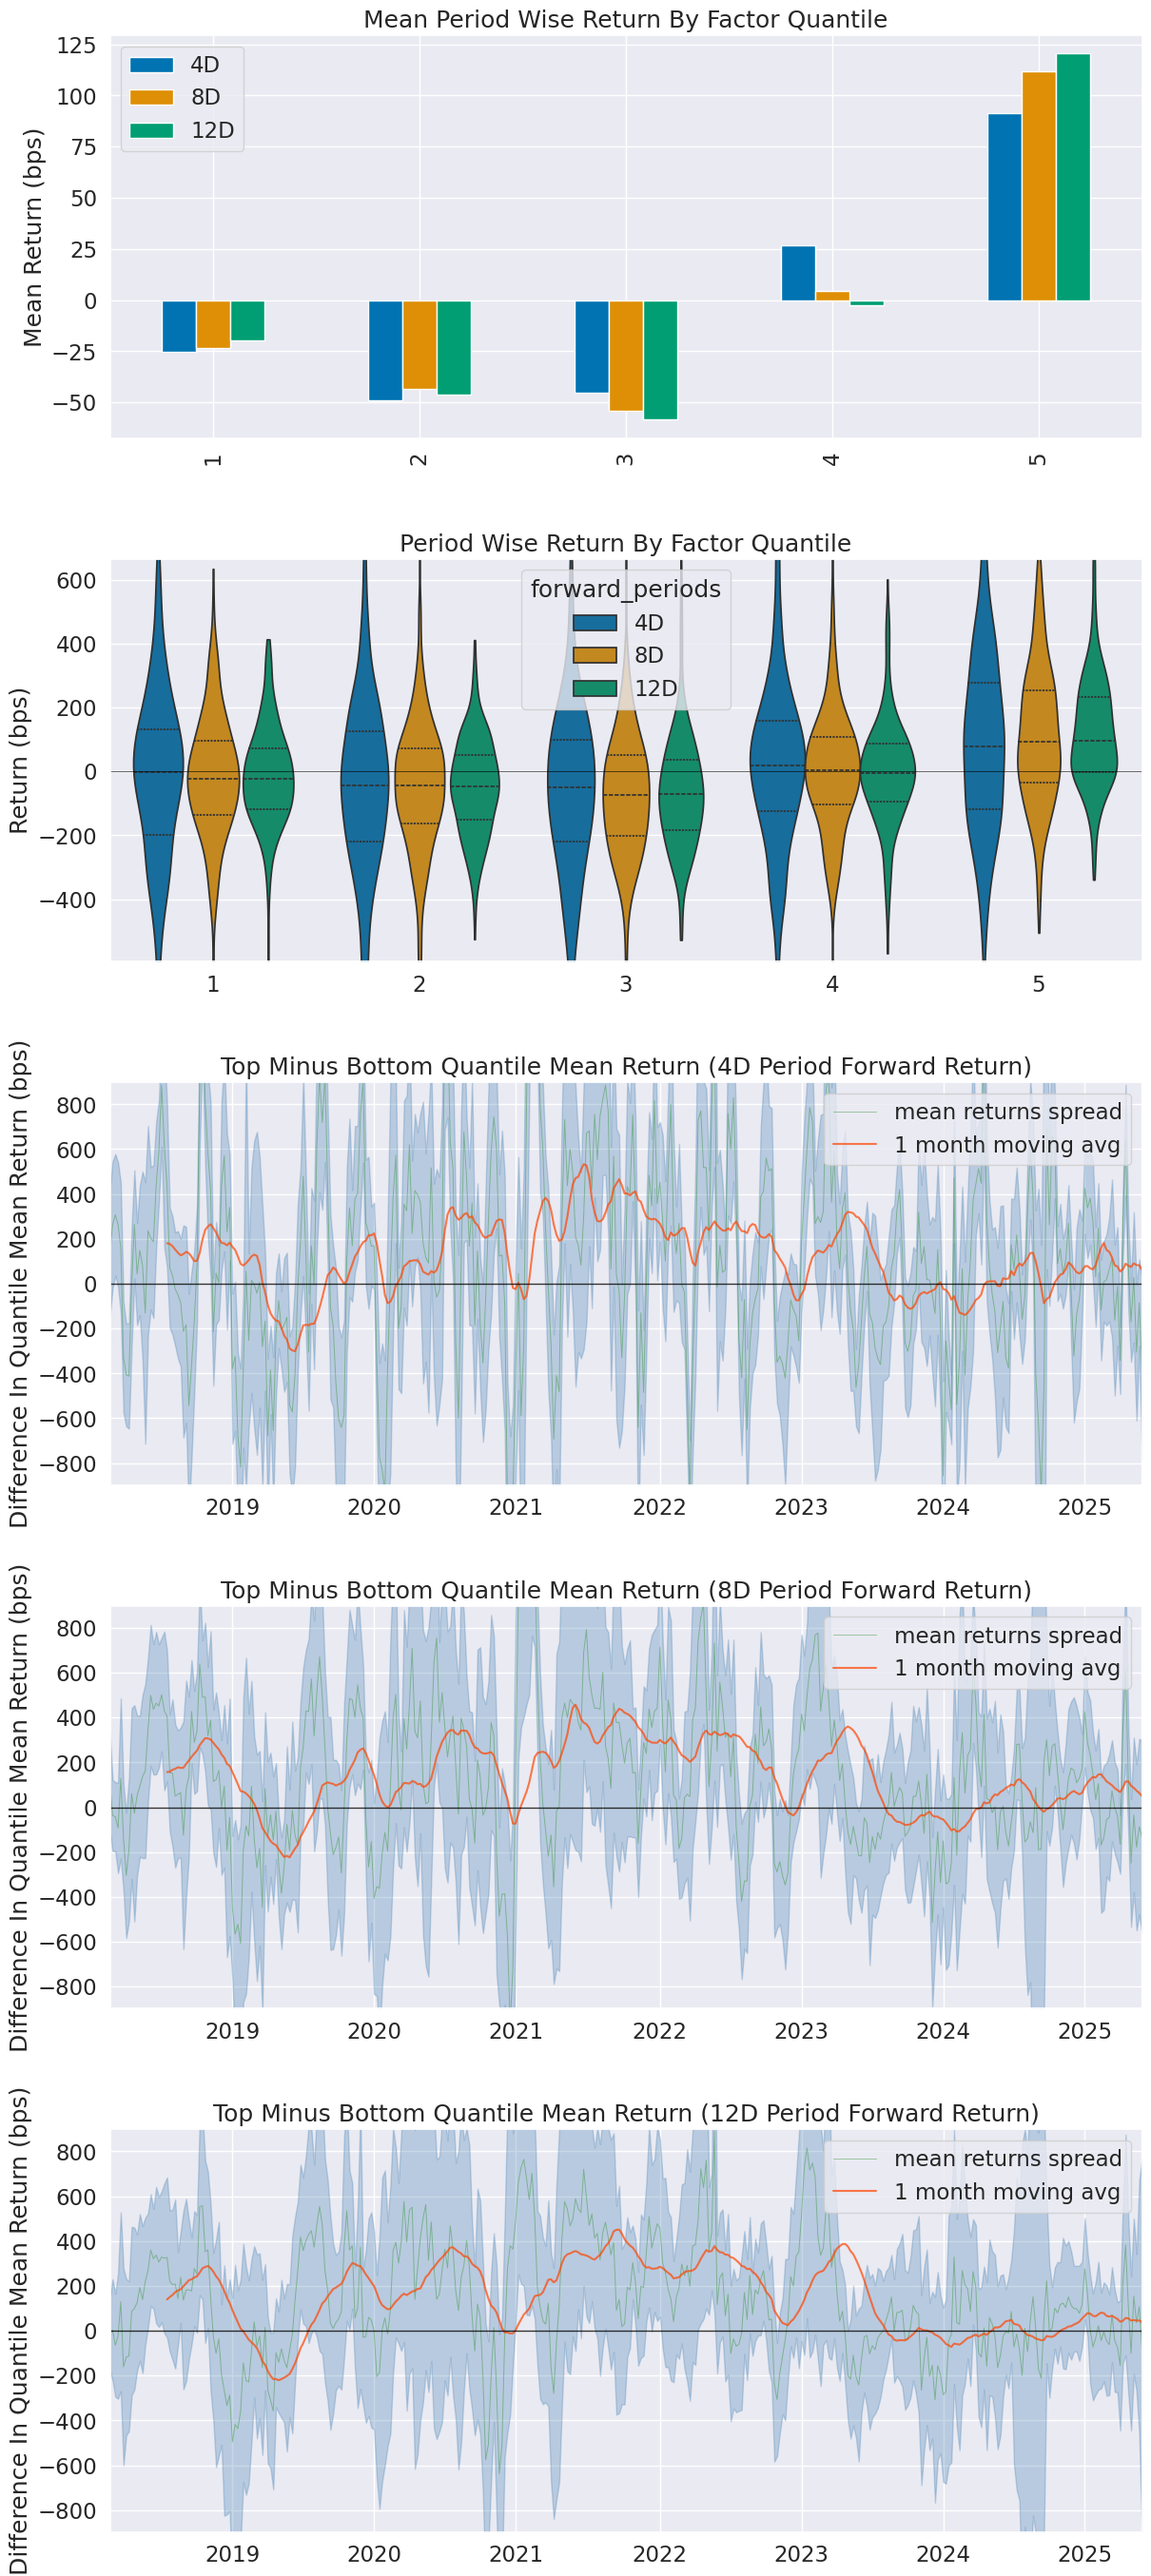

Information Analysis


,4D,8D,12D
IC Mean,0.044,0.063,0.089
IC Std.,0.172,0.166,0.153
Risk-Adjusted IC,0.253,0.380,0.578
t-stat(IC),4.930,7.417,11.263
p-value(IC),0.000,0.000,0.000
IC Skew,0.187,0.119,-0.118
IC Kurtosis,-0.184,-0.413,-0.717


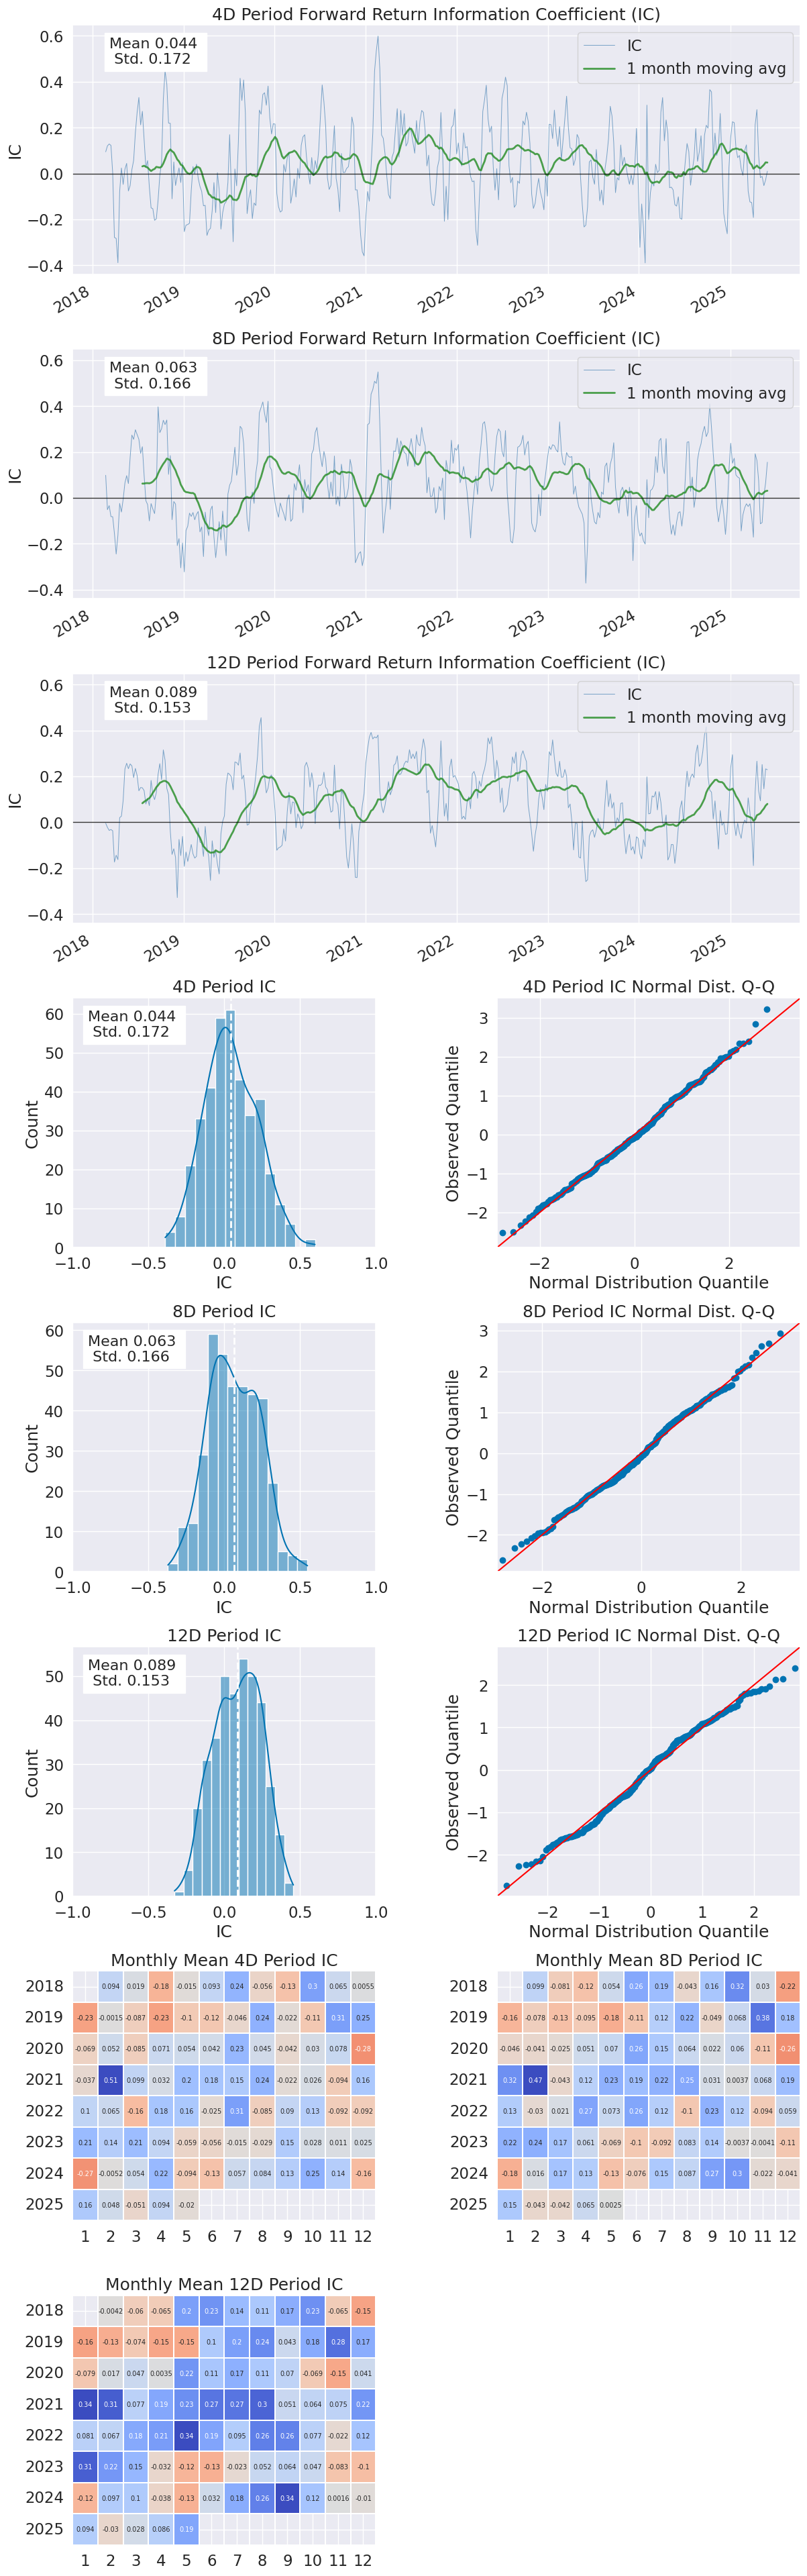

Turnover Analysis


,4D,8D,12D
Quantile 1 Mean Turnover,0.109,0.171,0.210
Quantile 2 Mean Turnover,0.238,0.322,0.379
Quantile 3 Mean Turnover,0.306,0.409,0.473
Quantile 4 Mean Turnover,0.300,0.407,0.473
Quantile 5 Mean Turnover,0.153,0.236,0.294


,4D,8D,12D
Mean Factor Rank Autocorrelation,0.932,0.873,0.83


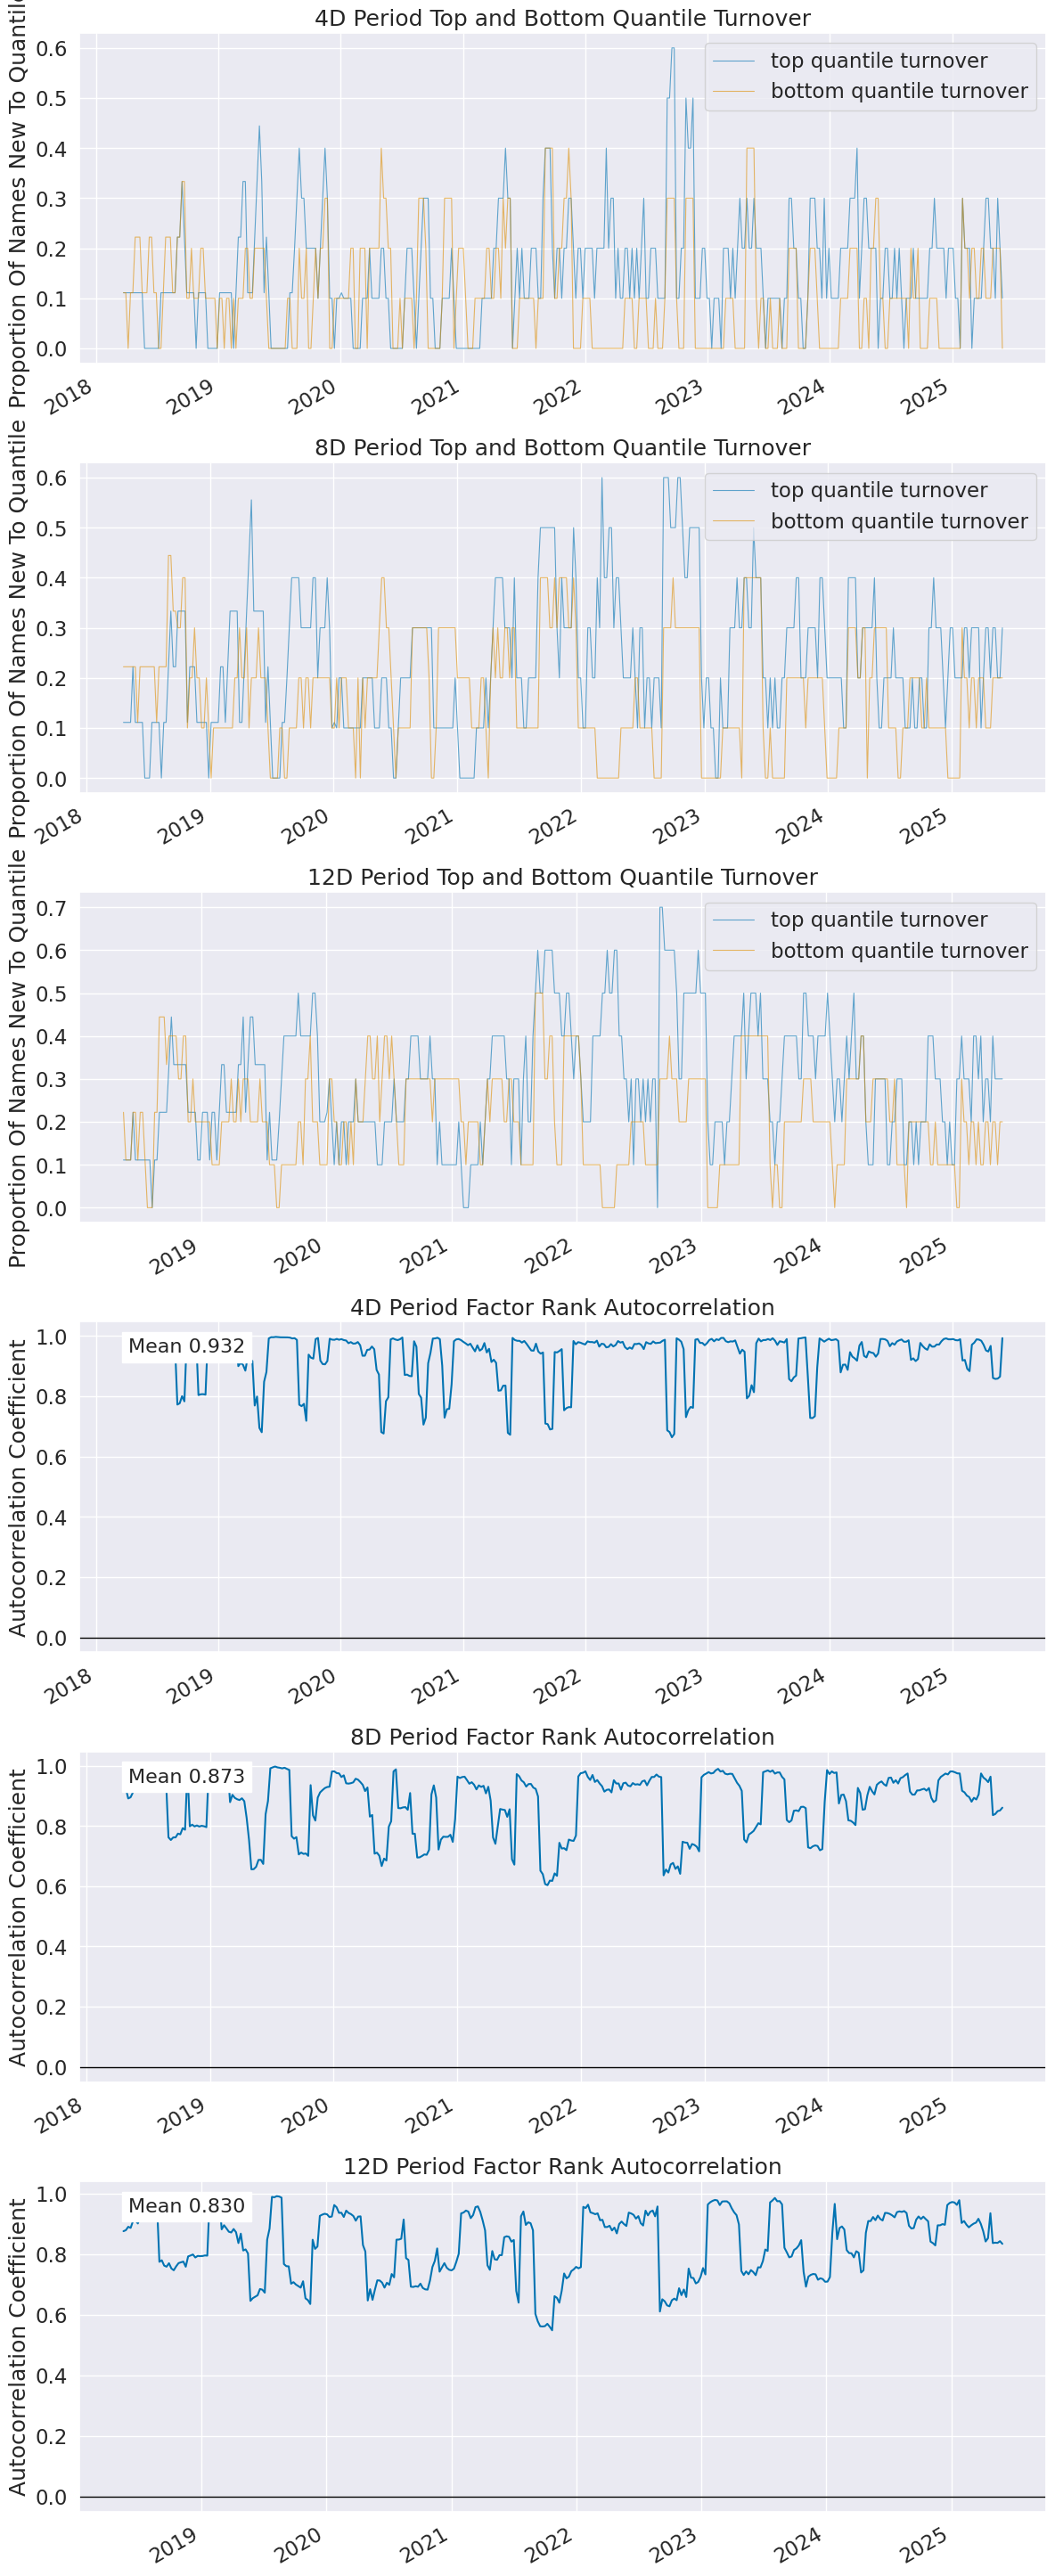

In [304]:
try:
    factor_data = get_clean_factor_and_forward_returns(
        factor=factor_series,
        prices=price_pivot_w,
        periods=[4, 8, 12],        # 4周、8周、12周前向收益
        max_loss=0.75,             # 允许 75% 数据缺失
        quantiles=5,               # 五分组
    )

    print("✅ 因子数据处理成功!")
    print(f"有效数据点: {len(factor_data)}")

    print("📊 正在生成 Alphalens 分析报告...")
    create_full_tear_sheet(
        factor_data=factor_data,
        long_short=True,        # 多空组合（推荐）
        group_neutral=False,    # 不做行业中性（可后续扩展）
        by_group=False          # 不分行业分析
    )

except Exception as e:
    print(f"❌ Alphalens 报告生成失败: {e}")
    import traceback
    traceback.print_exc()

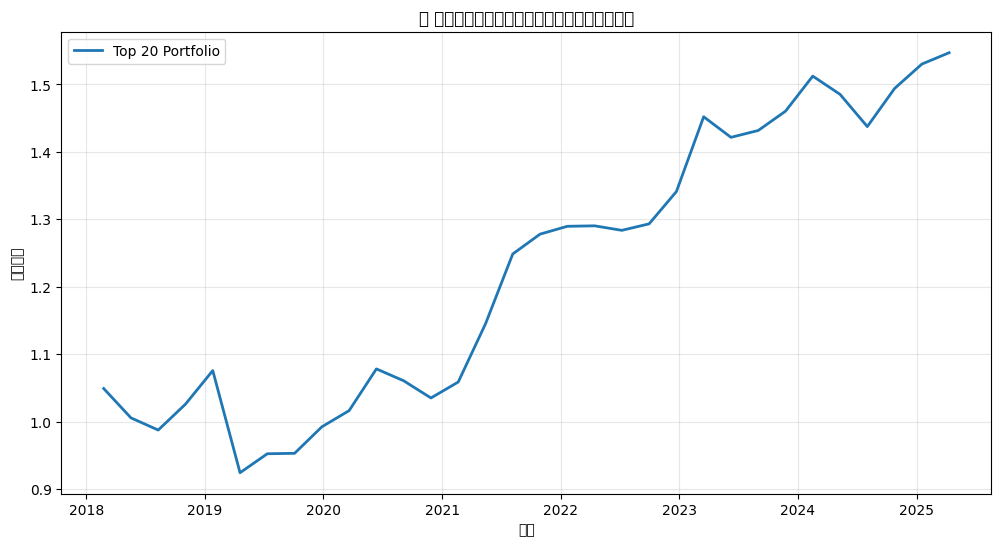

🎯 年化收益: 25.44%
📊 年化波动: 18.17%
📈 夏普比率: 1.40
📌 最大回撤: -14.08%


In [305]:
import matplotlib.pyplot as plt

# 获取下一期（如 12D）的收益
forward_returns = price_pivot.pct_change(12).shift(-12)  # 未来 12 天收益

def backtest_top_portfolio(factor_data, forward_returns, n=10, holding_period=12):
    """
    回测：每 period 选 top n，持有 holding_period 天
    """
    from datetime import timedelta

    dates = sorted(factor_data.index.get_level_values('date').unique())
    portfolio_returns = []
    for i, date in enumerate(dates):
        if i % 12 != 0:  # 每 12 周调仓一次（约每季度）
            continue

        # 选股
        factor_slice = factor_data.loc[date, 'factor']
        top_stocks = factor_slice.sort_values(ascending=False).head(n).index

        # 获取持有期收益（未来 12 天）
        end_date = date + timedelta(days=12*7)
        ret_slice = forward_returns.loc[date:end_date, top_stocks].iloc[0]  # 第一个收益

        if len(ret_slice) > 0:
            portfolio_return = ret_slice.mean()  # 等权
            portfolio_returns.append({'date': date, 'return': portfolio_return})

    perf = pd.DataFrame(portfolio_returns).set_index('date')
    perf['cumret'] = (1 + perf['return']).cumprod()

    # 绘图
    plt.figure(figsize=(12, 6))
    plt.plot(perf.index, perf['cumret'], label='Top 20 Portfolio', linewidth=2)
    plt.title("📈 因子选股组合累计收益（等权，每季度调仓）")
    plt.ylabel("累计收益")
    plt.xlabel("时间")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    ann_return = perf['return'].mean() * 52 / 3
    ann_vol = perf['return'].std() * np.sqrt(52 / 3)
    sharpe = ann_return / ann_vol if ann_vol != 0 else 0

    print(f"🎯 年化收益: {ann_return:.2%}")
    print(f"📊 年化波动: {ann_vol:.2%}")
    print(f"📈 夏普比率: {sharpe:.2f}")
    print(f"📌 最大回撤: {(perf['cumret'] / perf['cumret'].cummax() - 1).min():.2%}")

    return perf

# 运行回测
performance = backtest_top_portfolio(factor_data, forward_returns, n=10)